## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные в датафреймы (для рейтингов будем использовать таблицы с timestamp):

In [2]:
user_rate = pd.read_csv('movielens/user_ratedmovies-timestamps.dat', sep='\t')

#movie_actors = pd.read_csv('movielens/movie_actors.dat', sep='\t')
#movie_countries = pd.read_csv('movielens/movie_countries.dat', sep='\t')
#movie_directors = pd.read_csv('movielens/movie_directors.dat', sep='\t')
#movie_genres = pd.read_csv('movielens/movie_genres.dat', sep='\t')
#movie_locations = pd.read_csv('movielens/movie_locations.dat', sep='\t')
#movie_tags = pd.read_csv('movielens/movie_tags.dat', sep='\t')
#movies = pd.read_csv('movielens/movies.dat', sep='\t')
#tags = pd.read_csv('movielens/tags.dat', sep='\t')
#user_taggedmovies_timestamps = pd.read_csv('movielens/user_taggedmovies-timestamps.dat', sep='\t')

In [3]:
user_rate.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


Зададим константы для размерностей наших матриц:

In [4]:
USERMAX = max(user_rate.userID.unique()) + 1
USERMAX

71535

In [5]:
MOVIEMAX = max(user_rate.movieID.unique()) + 1 
MOVIEMAX

65134

Разобьем данные на три датафрейма, из которых потом получим матрицы:

In [6]:
def split_data(user_rates):
    cols = user_rates.columns
    idx = np.arange(0,len(user_rates.userID.unique())*5)
    test = pd.DataFrame(index=idx, columns=cols)
    val = pd.DataFrame(index=idx, columns=cols)
    j = 0
    k = 0
    todrop = []
    for uid in user_rates.userID.unique():
        temp = user_rate[user_rate['userID']==uid].sort_values(by='timestamp', ascending=False)
        for i in range(0,5):
            test.loc[j] = temp.iloc[i]
            todrop.append(temp.iloc[i].name)
            j+=1
        for i in range(5,10):
            val.loc[k] = temp.iloc[i]
            todrop.append(temp.iloc[i].name)
            k+=1
    train = user_rates.drop(todrop)
    test[['userID', 'movieID', 'timestamp']] = test[['userID', 'movieID', 'timestamp']].astype('int')
    val[['userID', 'movieID', 'timestamp']] = val[['userID', 'movieID', 'timestamp']].astype('int')
    test['rating'] = test['rating'].astype('float')
    val['rating'] = val['rating'].astype('float')
    return train, val, test

In [7]:
def make_matrixes(train, val, test, shapes):
    m_train = sparse.csr_matrix((train.rating.values, (train.userID.values, train.movieID.values)), shape=shapes)
    m_val = sparse.csr_matrix((val.rating.values, (val.userID.values, val.movieID.values)), shape=shapes)
    m_test = sparse.csr_matrix((test.rating.values, (test.userID.values, test.movieID.values)), shape=shapes)
    return m_train, m_val, m_test

In [8]:
%%time
train_df, val_df, test_df = split_data(user_rate)

CPU times: user 2min 18s, sys: 4 s, total: 2min 22s
Wall time: 2min 30s


In [9]:
len(train_df) + len(val_df) + len(test_df) == len(user_rate)

True

In [10]:
test_df.dtypes

userID         int64
movieID        int64
rating       float64
timestamp      int64
dtype: object

In [11]:
train_rates, val_rates, test_rates = make_matrixes(train_df, val_df, test_df, (USERMAX, MOVIEMAX))

In [12]:
val_rates

<71535x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10565 stored elements in Compressed Sparse Row format>

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [13]:
from sklearn.metrics import mean_squared_error

Вычисление DCG - нужно для nDCG. Возвращает $maxDCG$ и $DCG$.

In [14]:
def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    max_gain = 2**max(y_true) - 1
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(max_gain / discounts), np.sum(gains / discounts)

In [15]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    rmse = 0.0
    i = 0
    for row in y_predicted_:
        if row.any():
            ids = row.argsort()[::-1][:k]
            pred = row[ids]
            row_ = y_true_[i]
            real = row_[ids]
            rmse += mean_squared_error(real, pred)**0.5
            i+=1
    if i > 0:
        rmse = rmse/i
    return rmse


def ndcg_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    ndcg = 0.0
    users = 0
    for i in range(y_true.shape[0]):
        real_row = y_true_[i]
        pred_row = y_predicted_[i]
        best, actual = dcg_score(real_row, pred_row, k)
        if best:
            ndcg += actual/best
            users += 1
    if users > 0:
        ndcg = ndcg / users
    return ndcg

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [16]:
def most_pop_predict(X):
    X = X.tocoo()
    sums = np.ravel(X.sum(axis=0))
    counts = X.getnnz(axis=0)
    sums[counts.nonzero()] = sums[counts.nonzero()]/counts[counts.nonzero()] #our mean ratings
    Y = np.zeros(shape=X.shape)
    for i in X.getnnz(axis=1).nonzero()[0]:
        Y[i] = sums
    return sparse.csr_matrix(Y)

In [17]:
%%time
predicted_mp = most_pop_predict(train_rates + val_rates)

CPU times: user 1min 25s, sys: 53.5 s, total: 2min 19s
Wall time: 2min 42s


In [18]:
%%time
rmse_score(test_rates, predicted_mp, k=5)

CPU times: user 21.6 s, sys: 23.4 s, total: 45 s
Wall time: 47.8 s


5.0

In [19]:
%%time
ndcg_score(test_rates, predicted_mp, k=5)

CPU times: user 2min 17s, sys: 25.9 s, total: 2min 43s
Wall time: 2min 53s


0.14606834984270645

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [16]:
from sklearn.decomposition import TruncatedSVD

In [17]:
def SVD(train, val, rank, k=5):
    svd = TruncatedSVD(n_components=rank)
    transformed = svd.fit_transform(train)
    restored = svd.inverse_transform(transformed)
    rmse = rmse_score(val, restored, k)
    ndcg = ndcg_score(val, restored, k)
    return rmse, ndcg

In [22]:
%%time
SVD(train_rates, val_rates, rank=10)

CPU times: user 4min 6s, sys: 2min 47s, total: 6min 53s
Wall time: 7min 22s


(3.3593244176659787, 0.22130478921187666)

In [24]:
%%time
ranks = [5, 8, 10, 13, 15, 20, 25, 30, 50, 75]

rmses = []
ndcgs = []

for r in ranks:
    print('Decomposing for rank {} ...'.format(r))
    rmse, ndcg = SVD(train_rates, val_rates, rank=r)
    rmses.append(rmse)
    ndcgs.append(ndcg)
    print('RMSE: {:.3f}\nnDCG: {:.3f}'.format(rmse, ndcg))
    print('=================================')

Decomposing for rank 5 ...
RMSE: 3.127
nDCG: 0.234
Decomposing for rank 8 ...
RMSE: 3.294
nDCG: 0.232
Decomposing for rank 10 ...
RMSE: 3.358
nDCG: 0.220
Decomposing for rank 13 ...
RMSE: 3.493
nDCG: 0.226
Decomposing for rank 15 ...
RMSE: 3.535
nDCG: 0.224
Decomposing for rank 20 ...
RMSE: 3.652
nDCG: 0.211
Decomposing for rank 25 ...
RMSE: 3.738
nDCG: 0.208
Decomposing for rank 30 ...
RMSE: 3.786
nDCG: 0.208
Decomposing for rank 50 ...
RMSE: 3.957
nDCG: 0.206
Decomposing for rank 75 ...
RMSE: 4.083
nDCG: 0.176
CPU times: user 41min 46s, sys: 28min 9s, total: 1h 9min 56s
Wall time: 1h 11min 24s


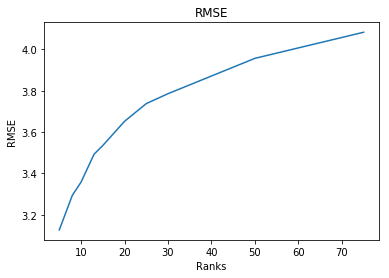

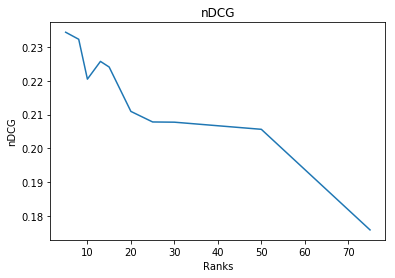

In [28]:
plt.plot(ranks, rmses)
plt.xlabel('Ranks')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.show()

plt.plot(ranks, ndcgs)
plt.xlabel('Ranks')
plt.ylabel('nDCG')
plt.title('nDCG')
plt.show()

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [18]:
from sklearn.metrics.pairwise import pairwise_distances

На первом шаге вычислим матрицу мер сходств пользователей:

In [19]:
%%time
user_similarity = pairwise_distances(train_rates, metric='cosine')

CPU times: user 1min 40s, sys: 3min 53s, total: 5min 33s
Wall time: 16min 51s


In [20]:
user_similarity[75]

array([ 1.        ,  1.        ,  1.        , ...,  1.        ,
        1.        ,  0.93515792])

Затем вычислим средние рейтинги пользователей:

In [21]:
def get_mean_ratings(X):
    sums = np.ravel(X.sum(axis=1))
    user_rates = np.zeros(shape=X.shape[0])
    for u in X.getnnz(axis=1).nonzero()[0]:
        user_rates[u] = sums[u] / X[u].getnnz()
    return user_rates

In [22]:
mean_ratings = get_mean_ratings(train_rates)
mean_ratings.shape

(71535,)

In [23]:
len(mean_ratings.nonzero()[0])

2113

In [24]:
def get_similar_users_with_coef(user, coefs, real, a=0.9):
    similar = []
    w = []
    for u in real:
        if u != user and coefs[u] > a:
            similar.append(u)
            w.append(coefs[u])
    return similar, w

In [25]:
def CF(X, sim_mtx, mean_r, a=0.9):
    real_users = X.getnnz(axis=1).nonzero()[0]
    Y = np.zeros(shape=X.shape)
    for u in real_users:
        rates = X[u].toarray()
        s, w = get_similar_users_with_coef(u, sim_mtx[u], real_users, a)
        weights_sum = sum(w)
        for i in range(len(rates)):
            similar_r_sum = 0.0
            for j in range(len(s)):
                v = s[j]
                if X[v,i]:
                    similar_r_sum += w[j] * (X[v,i] - mean_r[v])
            rate = mean_r[u] + similar_r_sum / weights_sum
            Y[u][i] = rate
    return sparse.csr_matrix(Y)

In [ ]:
%%time
predicted = CF(train_rates, user_similarity, mean_ratings)

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

$MostPop$, очевидно, показывает наихудший результат по обоим метрикам. Например, фильм был оценен только одним пользователем - он ему поставил максимальную оценку (5). Тогда такой фильм всегда будет в топе предложений для остальных.

$SVD$ работает существенно лучше, однако все равно значение RMSE достаточно велико (и увеличивается с увеличением ранга), а nDCG - достаточно низко.

Оценить работу user-based CF возможным не предоставилось из-за слишком долгого выполнения (в моем случае прошло больше часа, а выполнение так и не закончилось). По моим соображениям, результаты должны быть не хуже работы SVD.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

Можно использовать $MAE$ (Mean Absolute Error).

Если нам необходимо предсказать, понравится ли фильм или нет пользователю (т.е. задача сводится к бинарной), можно воспользоваться $Precision@k$ и $Recall@k$, а также весьма популярной $map@K$